<a href="https://colab.research.google.com/github/M7xm6/temp_llama/blob/main/Llama_2_7b_chat_hf3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 142.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0


In [1]:
from google.colab import files

uploaded = files.upload()


Saving parts.xlsx to parts.xlsx


In [2]:
from google.colab import files

uploaded = files.upload()


Saving deepseek_experiment_raw.csv to deepseek_experiment_raw.csv


## Local Inference on GPU
Model page: https://huggingface.co/meta-llama/Llama-2-7b-chat-hf

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

The model you are trying to use is gated. Please make sure you have access to it by visiting the model page.To run inference, either set HF_TOKEN in your environment variables/ Secrets or run the following cell to login. 🤗

In [14]:
from huggingface_hub import login
login()

🚀 开始Llama2基准测试实验

📂 加载DeepSeek实验数据...
✅ 成功加载 98 条数据

🔧 初始化Llama2模型...
   设备: cuda
   GPU: NVIDIA A100-SXM4-80GB
   显存: 85.09 GB


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

✅ 模型加载完成!

🔬 开始Llama2推理实验...

问题 1/98
内容: 设 G 是一个有 n 个顶点（n≥2）的简单图。证明：如果对于 G 中任意两个不相邻的顶点 u 和 v，都有 deg(u...
----------------------------------------------------------------------
✅ 完成! 用时: 17.67秒, Tokens: 553
回答: This is a classic result in graph theory, known as the "Handbook of Graph Theory...

问题 2/98
内容: 考虑一个 m 行 n 列的矩形网格图（顶点坐标为 (i,j)，1≤i≤m，1≤j≤n，相邻当且仅当坐标差一个为 1）。证...
----------------------------------------------------------------------
✅ 完成! 用时: 26.33秒, Tokens: 910
回答: To prove that a m x n grid graph always contains a Hamiltonian path when m and n...

问题 3/98
内容: 构造一个最小度数为 2 的简单连通图，使其没有哈密顿路径（要求顶点数尽可能少），并证明你构造的图确实没有哈密顿路径。...
----------------------------------------------------------------------
✅ 完成! 用时: 17.52秒, Tokens: 581
回答: To construct a simple connected graph with minimum degree 2 that does not have a...

问题 4/98
内容: 求在 1 到 1000 中，有多少个数的十进制表示中各位数字之和等于 10？（数位DP典型问题，代替文档中的图）...
----------------------------------------------------------------------
✅ 完成! 用时: 19.02秒, Tokens: 607
回

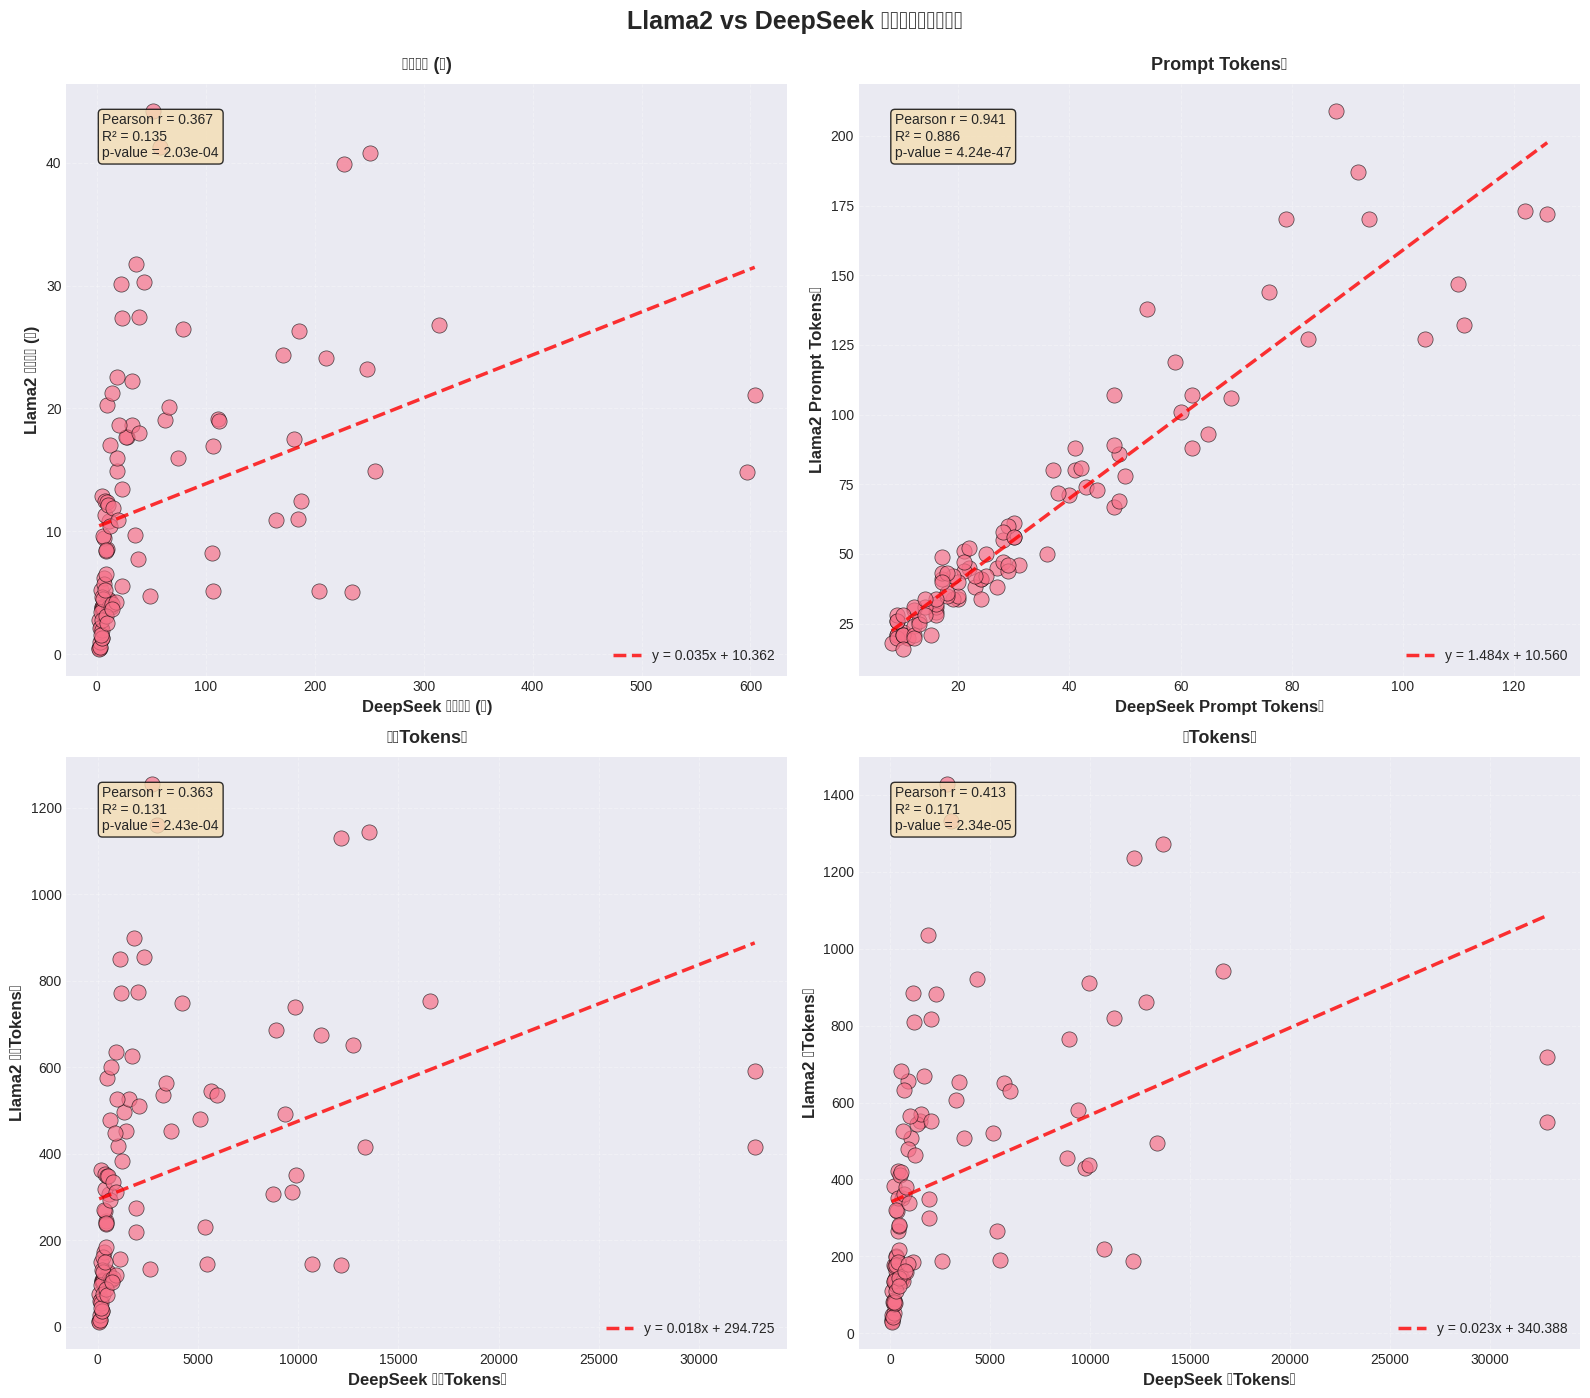

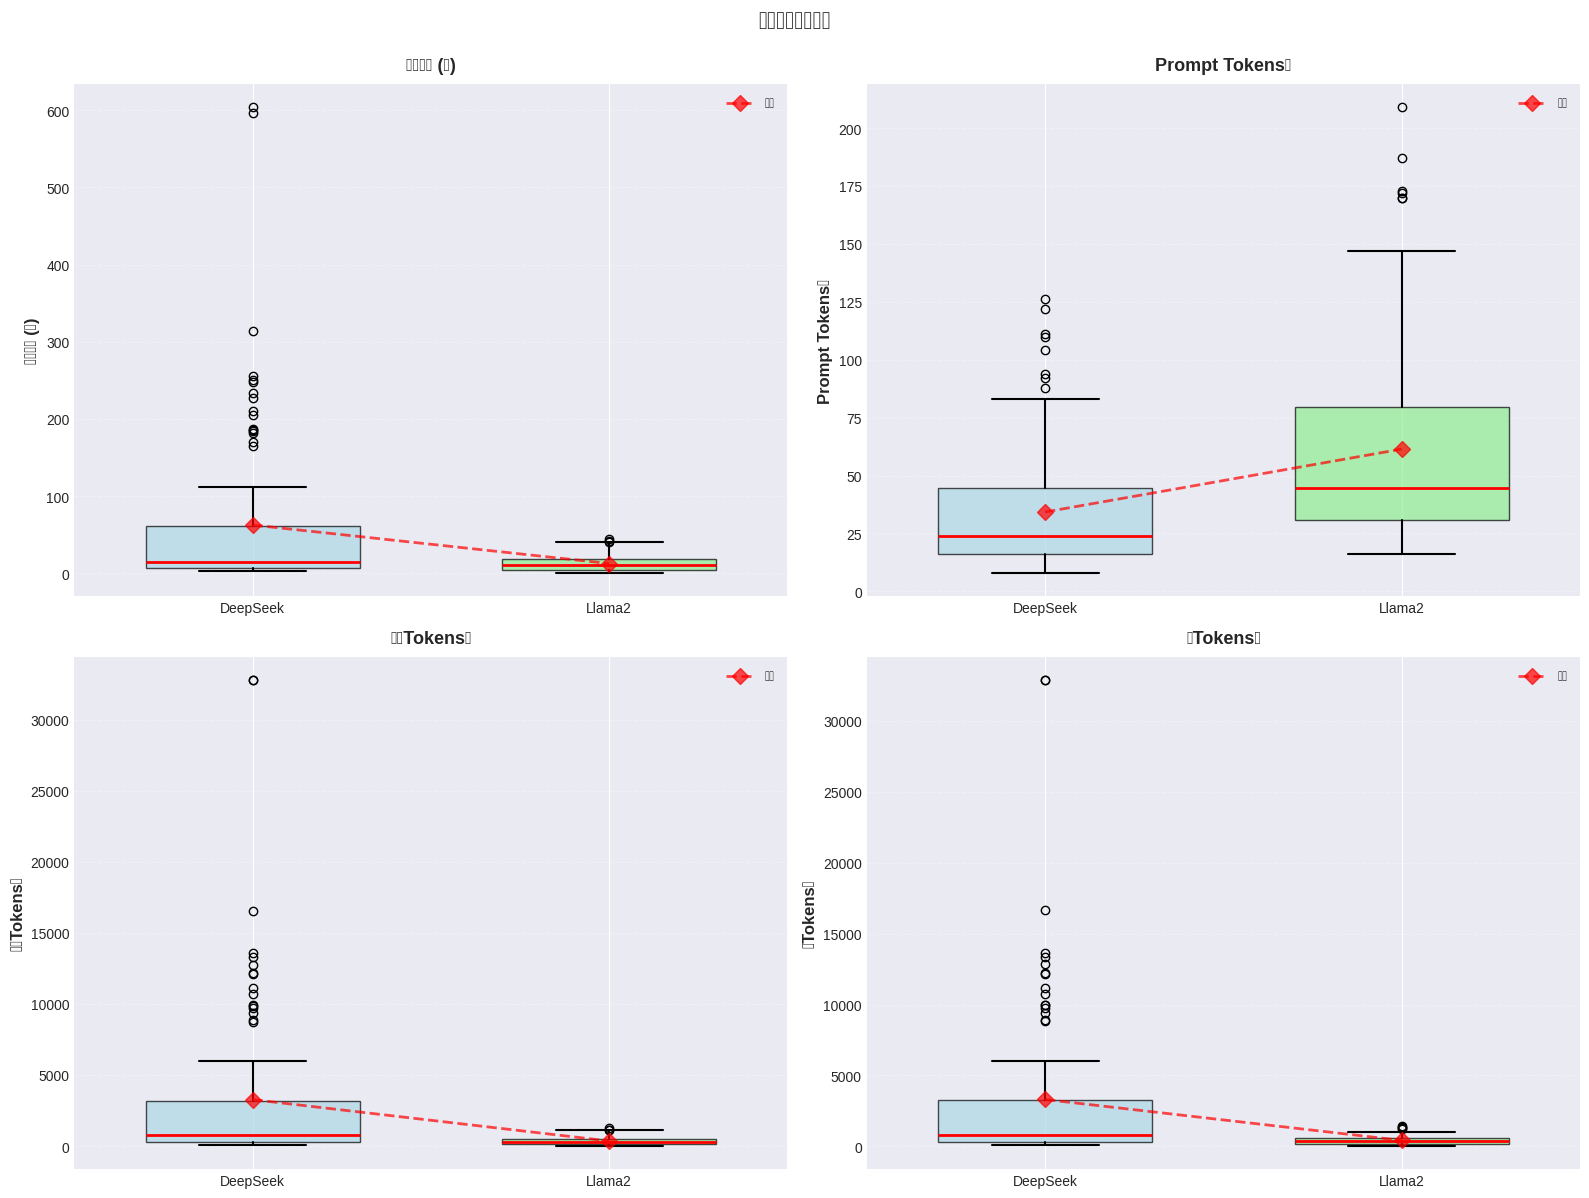

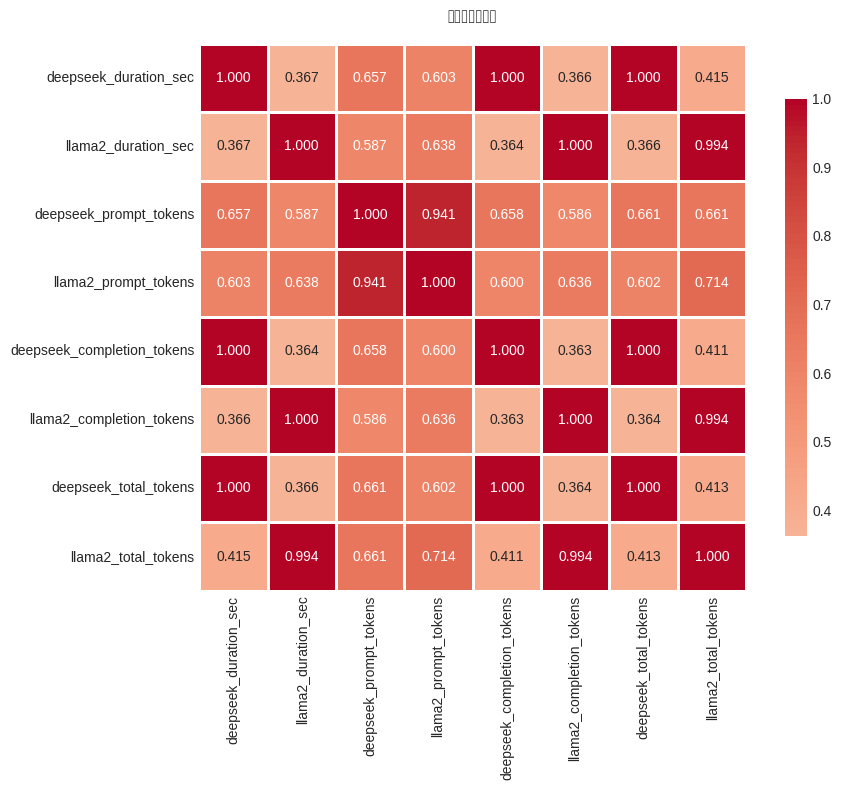

In [15]:
# Llama2 实验 - 增强版 (包含更多统计分析)
# 在Google Colab中运行此脚本

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import time
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# 设置绘图样式
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class Llama2Benchmark:
    """Llama2基准测试类"""

    def __init__(self, model_name="meta-llama/Llama-2-7b-chat-hf"):
        self.model_name = model_name
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self._setup_model()

    def _setup_model(self):
        """初始化模型和tokenizer"""
        print("🔧 初始化Llama2模型...")
        print(f"   设备: {self.device}")

        if self.device == "cuda":
            print(f"   GPU: {torch.cuda.get_device_name(0)}")
            print(f"   显存: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            torch_dtype=torch.float16 if self.device == "cuda" else torch.float32,
            device_map="auto",
            low_cpu_mem_usage=True
        )

        print("✅ 模型加载完成!\n")

    def infer(self, question: str, max_new_tokens: int = 2048) -> Tuple[str, float, int, int, int]:
        """
        执行推理
        返回: (answer, duration_sec, prompt_tokens, completion_tokens, total_tokens)
        """
        # Llama2 Chat模板
        prompt = f"<s>[INST] {question} [/INST]"

        # Token化
        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True).to(self.device)
        prompt_tokens = inputs['input_ids'].shape[1]

        # 计时开始
        torch.cuda.synchronize() if self.device == "cuda" else None
        start_time = time.time()

        # 生成
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                temperature=0.7,
                top_p=0.9,
                do_sample=True,
                pad_token_id=self.tokenizer.eos_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        # 计时结束
        torch.cuda.synchronize() if self.device == "cuda" else None
        duration = time.time() - start_time

        # 解码
        full_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        prompt_text = self.tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)
        answer = full_text[len(prompt_text):].strip()

        # Token统计
        total_tokens = outputs.shape[1]
        completion_tokens = total_tokens - prompt_tokens

        # 清理显存
        if self.device == "cuda":
            torch.cuda.empty_cache()

        return answer, duration, prompt_tokens, completion_tokens, total_tokens

def comprehensive_correlation_analysis(df: pd.DataFrame) -> Dict:
    """全面的相关性分析"""

    metrics = ['duration_sec', 'prompt_tokens', 'completion_tokens', 'total_tokens']
    results = {}

    print("\n" + "="*70)
    print("📊 详细相关性分析")
    print("="*70)

    for metric in metrics:
        x = df[f'deepseek_{metric}'].values
        y = df[f'llama2_{metric}'].values

        # 1. Pearson相关 (线性相关)
        pearson_r, pearson_p = stats.pearsonr(x, y)

        # 2. Spearman相关 (秩相关,适用于非线性)
        spearman_r, spearman_p = stats.spearmanr(x, y)

        # 3. Kendall相关 (另一种秩相关)
        kendall_tau, kendall_p = stats.kendalltau(x, y)

        # 4. 线性回归
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        # 5. 决定系数
        r_squared = r_value ** 2

        # 存储结果
        results[metric] = {
            'pearson_r': pearson_r,
            'pearson_p': pearson_p,
            'spearman_r': spearman_r,
            'spearman_p': spearman_p,
            'kendall_tau': kendall_tau,
            'kendall_p': kendall_p,
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_squared,
            'regression_p': p_value,
            'std_err': std_err
        }

        # 打印结果
        print(f"\n📈 {metric.upper()}")
        print("-" * 70)
        print(f"  相关系数:")
        print(f"    • Pearson  r = {pearson_r:7.4f}  (p={pearson_p:.4e}) {'✅ 显著' if pearson_p < 0.05 else '❌ 不显著'}")
        print(f"    • Spearman ρ = {spearman_r:7.4f}  (p={spearman_p:.4e}) {'✅ 显著' if spearman_p < 0.05 else '❌ 不显著'}")
        print(f"    • Kendall  τ = {kendall_tau:7.4f}  (p={kendall_p:.4e}) {'✅ 显著' if kendall_p < 0.05 else '❌ 不显著'}")
        print(f"\n  线性回归:")
        print(f"    • 方程: Llama2 = {slope:.4f} × DeepSeek + {intercept:.4f}")
        print(f"    • R² = {r_squared:.4f} (解释了{r_squared*100:.2f}%的方差)")
        print(f"    • 标准误差 = {std_err:.4f}")

        # 相关强度判断
        abs_r = abs(pearson_r)
        if abs_r > 0.7:
            strength = "强相关 💪"
        elif abs_r > 0.4:
            strength = "中等相关 👌"
        else:
            strength = "弱相关 😐"
        print(f"    • 相关强度: {strength}")

    return results

def create_visualizations(df: pd.DataFrame, correlations: Dict):
    """创建可视化图表"""

    metrics = ['duration_sec', 'prompt_tokens', 'completion_tokens', 'total_tokens']
    metric_labels = {
        'duration_sec': '运行时长 (秒)',
        'prompt_tokens': 'Prompt Tokens数',
        'completion_tokens': '生成Tokens数',
        'total_tokens': '总Tokens数'
    }

    # 图1: 散点图 + 回归线
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle('Llama2 vs DeepSeek 资源消耗相关性分析', fontsize=18, fontweight='bold', y=0.995)

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]

        x = df[f'deepseek_{metric}']
        y = df[f'llama2_{metric}']

        # 散点图
        ax.scatter(x, y, alpha=0.7, s=120, edgecolors='black', linewidth=0.5)

        # 回归线
        corr = correlations[metric]
        x_line = np.linspace(x.min(), x.max(), 100)
        y_line = corr['slope'] * x_line + corr['intercept']
        ax.plot(x_line, y_line, 'r--', linewidth=2.5, alpha=0.8,
                label=f"y = {corr['slope']:.3f}x + {corr['intercept']:.3f}")

        # 添加统计信息
        textstr = f"Pearson r = {corr['pearson_r']:.3f}\n"
        textstr += f"R² = {corr['r_squared']:.3f}\n"
        textstr += f"p-value = {corr['pearson_p']:.2e}"
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)

        ax.set_xlabel(f'DeepSeek {metric_labels[metric]}', fontsize=12, fontweight='bold')
        ax.set_ylabel(f'Llama2 {metric_labels[metric]}', fontsize=12, fontweight='bold')
        ax.set_title(metric_labels[metric], fontsize=13, fontweight='bold', pad=10)
        ax.legend(loc='lower right', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
    print("\n✅ 保存图表: correlation_analysis.png")

    # 图2: 分布对比
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('资源消耗分布对比', fontsize=18, fontweight='bold', y=0.995)

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]

        data = [df[f'deepseek_{metric}'], df[f'llama2_{metric}']]
        labels = ['DeepSeek', 'Llama2']

        bp = ax.boxplot(data, labels=labels, patch_artist=True, widths=0.6,
                       boxprops=dict(facecolor='lightblue', alpha=0.7),
                       medianprops=dict(color='red', linewidth=2),
                       whiskerprops=dict(linewidth=1.5),
                       capprops=dict(linewidth=1.5))

        # 颜色
        colors = ['lightblue', 'lightgreen']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        # 添加均值
        means = [d.mean() for d in data]
        ax.plot([1, 2], means, 'D--', color='red', linewidth=2, markersize=8,
                label='均值', alpha=0.7)

        ax.set_ylabel(metric_labels[metric], fontsize=12, fontweight='bold')
        ax.set_title(metric_labels[metric], fontsize=13, fontweight='bold', pad=10)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')

    plt.tight_layout()
    plt.savefig('distribution_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ 保存图表: distribution_comparison.png")

    # 图3: 相关性热力图
    fig, ax = plt.subplots(figsize=(10, 8))

    corr_matrix = []
    for metric in metrics:
        corr_matrix.append([correlations[metric]['pearson_r']])

    # 创建更详细的相关性矩阵
    detailed_metrics = []
    for m in metrics:
        detailed_metrics.extend([f'ds_{m}', f'll_{m}'])

    # 构建完整相关性矩阵
    all_data = []
    for metric in metrics:
        all_data.append(df[f'deepseek_{metric}'])
        all_data.append(df[f'llama2_{metric}'])

    corr_df = pd.DataFrame(all_data).T.corr()

    sns.heatmap(corr_df, annot=True, fmt='.3f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
    ax.set_title('完整相关性矩阵', fontsize=14, fontweight='bold', pad=15)

    plt.tight_layout()
    plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
    print("✅ 保存图表: correlation_heatmap.png")

def generate_report(df: pd.DataFrame, correlations: Dict):
    """生成详细报告"""

    report = []
    report.append("="*70)
    report.append("📋 LLAMA2 vs DEEPSEEK 实验报告")
    report.append("="*70)
    report.append("")

    # 基本统计
    report.append("1️⃣ 基本统计信息")
    report.append("-"*70)
    report.append(f"  测试问题数: {len(df)}")
    report.append("")

    metrics = ['duration_sec', 'prompt_tokens', 'completion_tokens', 'total_tokens']
    for metric in metrics:
        ds_mean = df[f'deepseek_{metric}'].mean()
        ll_mean = df[f'llama2_{metric}'].mean()
        ratio = ll_mean / ds_mean if ds_mean > 0 else 0

        report.append(f"  {metric}:")
        report.append(f"    DeepSeek 均值: {ds_mean:.2f}")
        report.append(f"    Llama2   均值: {ll_mean:.2f}")
        report.append(f"    比值(L/D):     {ratio:.2f}x")
        report.append("")

    # 相关性总结
    report.append("2️⃣ 相关性总结")
    report.append("-"*70)
    for metric in metrics:
        corr = correlations[metric]
        report.append(f"  {metric}:")
        report.append(f"    Pearson r = {corr['pearson_r']:.4f} (p={corr['pearson_p']:.4e})")
        report.append(f"    R² = {corr['r_squared']:.4f}")
        report.append(f"    线性关系: {'✅ 强' if abs(corr['pearson_r']) > 0.7 else '⚠️ 中' if abs(corr['pearson_r']) > 0.4 else '❌ 弱'}")
        report.append("")

    # 结论
    report.append("3️⃣ 结论")
    report.append("-"*70)

    avg_r = np.mean([correlations[m]['pearson_r'] for m in metrics])
    if avg_r > 0.7:
        conclusion = "✅ 两个模型的资源消耗呈现强正相关,说明问题复杂度对两个模型的影响是一致的。"
    elif avg_r > 0.4:
        conclusion = "⚠️ 两个模型的资源消耗呈现中等相关,存在一定的线性关系。"
    else:
        conclusion = "❌ 两个模型的资源消耗相关性较弱,可能受不同因素影响。"

    report.append(f"  {conclusion}")
    report.append("")
    report.append("="*70)

    # 打印并保存报告
    report_text = "\n".join(report)
    print("\n" + report_text)

    with open('experiment_report.txt', 'w', encoding='utf-8') as f:
        f.write(report_text)
    print("\n💾 报告已保存到: experiment_report.txt")

# ============= 主程序 =============
def main():
    print("🚀 开始Llama2基准测试实验\n")

    # 1. 加载DeepSeek数据
    print("📂 加载DeepSeek实验数据...")
    df_deepseek = pd.read_csv('deepseek_experiment_raw.csv')
    print(f"✅ 成功加载 {len(df_deepseek)} 条数据\n")

    # 2. 初始化Llama2
    benchmark = Llama2Benchmark()

    # 3. 运行实验
    print("🔬 开始Llama2推理实验...\n")
    results = []

    for idx, row in df_deepseek.iterrows():
        question = row['question']
        print(f"{'='*70}")
        print(f"问题 {idx + 1}/{len(df_deepseek)}")
        print(f"内容: {question[:60]}...")
        print("-"*70)

        try:
            answer, duration, p_tok, c_tok, t_tok = benchmark.infer(question)

            result = {
                'question_idx': row['question_idx'],
                'question': question,
                'llama2_answer': answer[:500],  # 截取前500字符
                'llama2_duration_sec': duration,
                'llama2_prompt_tokens': p_tok,
                'llama2_completion_tokens': c_tok,
                'llama2_total_tokens': t_tok,
                'deepseek_duration_sec': row['duration_sec'],
                'deepseek_prompt_tokens': row['prompt_tokens'],
                'deepseek_completion_tokens': row['completion_tokens'],
                'deepseek_total_tokens': row['total_tokens'],
            }

            results.append(result)

            print(f"✅ 完成! 用时: {duration:.2f}秒, Tokens: {t_tok}")
            print(f"回答: {answer[:80]}...\n")

        except Exception as e:
            print(f"❌ 错误: {str(e)}\n")
            continue

    # 4. 保存结果
    df_results = pd.DataFrame(results)
    df_results.to_csv('llama2_results_detailed.csv', index=False)
    print(f"\n💾 结果已保存: llama2_results_detailed.csv\n")

    # 5. 相关性分析
    correlations = comprehensive_correlation_analysis(df_results)

    # 6. 可视化
    print("\n📊 生成可视化图表...")
    create_visualizations(df_results, correlations)

    # 7. 生成报告
    generate_report(df_results, correlations)

    print("\n🎉 所有分析完成!")
    print("\n生成的文件:")
    print("  1. llama2_results_detailed.csv - 详细实验数据")
    print("  2. correlation_analysis.png - 相关性散点图")
    print("  3. distribution_comparison.png - 分布对比箱线图")
    print("  4. correlation_heatmap.png - 相关性热力图")
    print("  5. experiment_report.txt - 实验报告")

if __name__ == "__main__":
    main()